In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
 
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [4]:

data=pd.read_csv('amazon_reviews_1.csv')

In [5]:
data.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review,review_category
0,35311,UK,4652511,R2PF9XCB2AOY7C,B00MNYTWMI,174964168,Midnight Castle – A Free Hidden Object Mystery...,Mobile_Apps,5,0,1,N,Y,2014-09-16,"Addictive game Very good game, the graphics ar...",1
1,44590,UK,8778070,R2OVRHVTCC7U18,B00I8Q77Y0,370420344,Flappy Wings (not Flappy Bird),Mobile_Apps,2,1,2,N,Y,2014-02-16,Where to start? I came on here because I wante...,0
2,90295,UK,8476187,RRPSNSVU2RNE4,B008PEHK6U,173475712,Man of Steel [DVD],Video DVD,3,1,5,N,N,2013-12-28,Really Disappointed in this Film I have to say...,0
3,38798,UK,4329864,R1WK44Y81XH276,B00NWLIW0E,13526192,Goat Simulator,Mobile_Apps,1,3,5,N,N,2014-12-26,"Rubbish game When I tried to open it, it said ...",0
4,43364,UK,8080547,R2UL591NPU40SN,B00HRC40T6,887316735,Shadow Blade,Mobile_Apps,1,0,0,N,Y,2015-06-29,One Star Come on,0


In [6]:
data.columns

Index(['Unnamed: 0', 'marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_date', 'review', 'review_category'],
      dtype='object')

**Showing unique elements in attributes**

In [7]:
l=['marketplace','product_category','verified_purchase','vine','review_category','helpful_votes', 'total_votes']

for i in l:
  print('The unique element in : ', i)
  print('-'*30)
  print(data[i].unique())
  print()

The unique element in :  marketplace
------------------------------
['UK']

The unique element in :  product_category
------------------------------
['Mobile_Apps' 'Video DVD' 'Music' 'Books']

The unique element in :  verified_purchase
------------------------------
['Y' 'N']

The unique element in :  vine
------------------------------
['N' 'Y']

The unique element in :  review_category
------------------------------
[1 0]

The unique element in :  helpful_votes
------------------------------
[  0   1   3   5  14   2   4  29  32   9   6  13  20  19  17   7  22  15
  18  28  31   8  10  11 190 100  30  16  42  12  38  35 102  95  27  69
  37  49  36  84 133  68 184  62  43  26  24  44  21 419  33  77  25 109
  97  39  76  56 175  46  23  80 166  34  48  63 292  41  86 127  58  70
  53  79  45 229 163  51 380 105  47 297 244  55 117 103  50  75 135 101
  90]

The unique element in :  total_votes
------------------------------
[  1   2   5   0  33  41  10   3   4  19  11  45   8  31   6

In [8]:
data['marketplace'].value_counts()

UK    10000
Name: marketplace, dtype: int64

In [9]:
data['verified_purchase'].value_counts()

Y    8119
N    1881
Name: verified_purchase, dtype: int64

In [10]:
data.shape

(10000, 16)

In [11]:
data.describe()

,Unnamed: 0,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_category
count,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,49541.985100,1.048992e+07,4.897918e+08,3.474700,2.062000,4.303600,0.495400
std,28970.879761,7.948781e+06,2.875901e+08,1.511022,11.036228,15.439814,0.500004
min,22.000000,1.713900e+04,2.254720e+05,1.000000,0.000000,0.000000,0.000000
25%,23836.500000,4.485576e+06,2.454499e+08,2.000000,0.000000,0.000000,0.000000
50%,49684.500000,6.426075e+06,4.925619e+08,3.000000,0.000000,0.000000,0.000000
75%,74718.750000,1.799507e+07,7.424791e+08,5.000000,1.000000,3.000000,1.000000
max,99999.000000,2.919140e+07,9.997207e+08,5.000000,419.000000,493.000000,1.000000


In [12]:
data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

**Checking duplicate values but here is no duplicate value in even in a single column**

 **Handeling null values**

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         10000 non-null  int64 
 1   marketplace        10000 non-null  object
 2   customer_id        10000 non-null  int64 
 3   review_id          10000 non-null  object
 4   product_id         10000 non-null  object
 5   product_parent     10000 non-null  int64 
 6   product_title      10000 non-null  object
 7   product_category   10000 non-null  object
 8   star_rating        10000 non-null  int64 
 9   helpful_votes      10000 non-null  int64 
 10  total_votes        10000 non-null  int64 
 11  vine               10000 non-null  object
 12  verified_purchase  10000 non-null  object
 13  review_date        10000 non-null  object
 14  review             9999 non-null   object
 15  review_category    10000 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 1.2+

In [14]:
data.isnull()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review,review_category
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
data.isnull().sum()

Unnamed: 0           0
marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_date          0
review               1
review_category      0
dtype: int64

**There is one null value in review so we have to resolve this problem so here to get rid of this i am droping this entire raw value**

In [16]:
#drop null value
data.dropna(inplace=True)

In [17]:
data.isnull().sum()

Unnamed: 0           0
marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_date          0
review               0
review_category      0
dtype: int64

In [18]:
data.shape

(9999, 16)

**After droping row there is no row having null value**

In [19]:
for i in range(0,len(data)-1):
    if type(data.iloc[i]['product_title'])!= str:
        data.iloc[i]['product_title'] = str(data.iloc[i]['product_title'])

**Plotting histogram and plots to analysis data**


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc627990d0>,
      dtype=object)

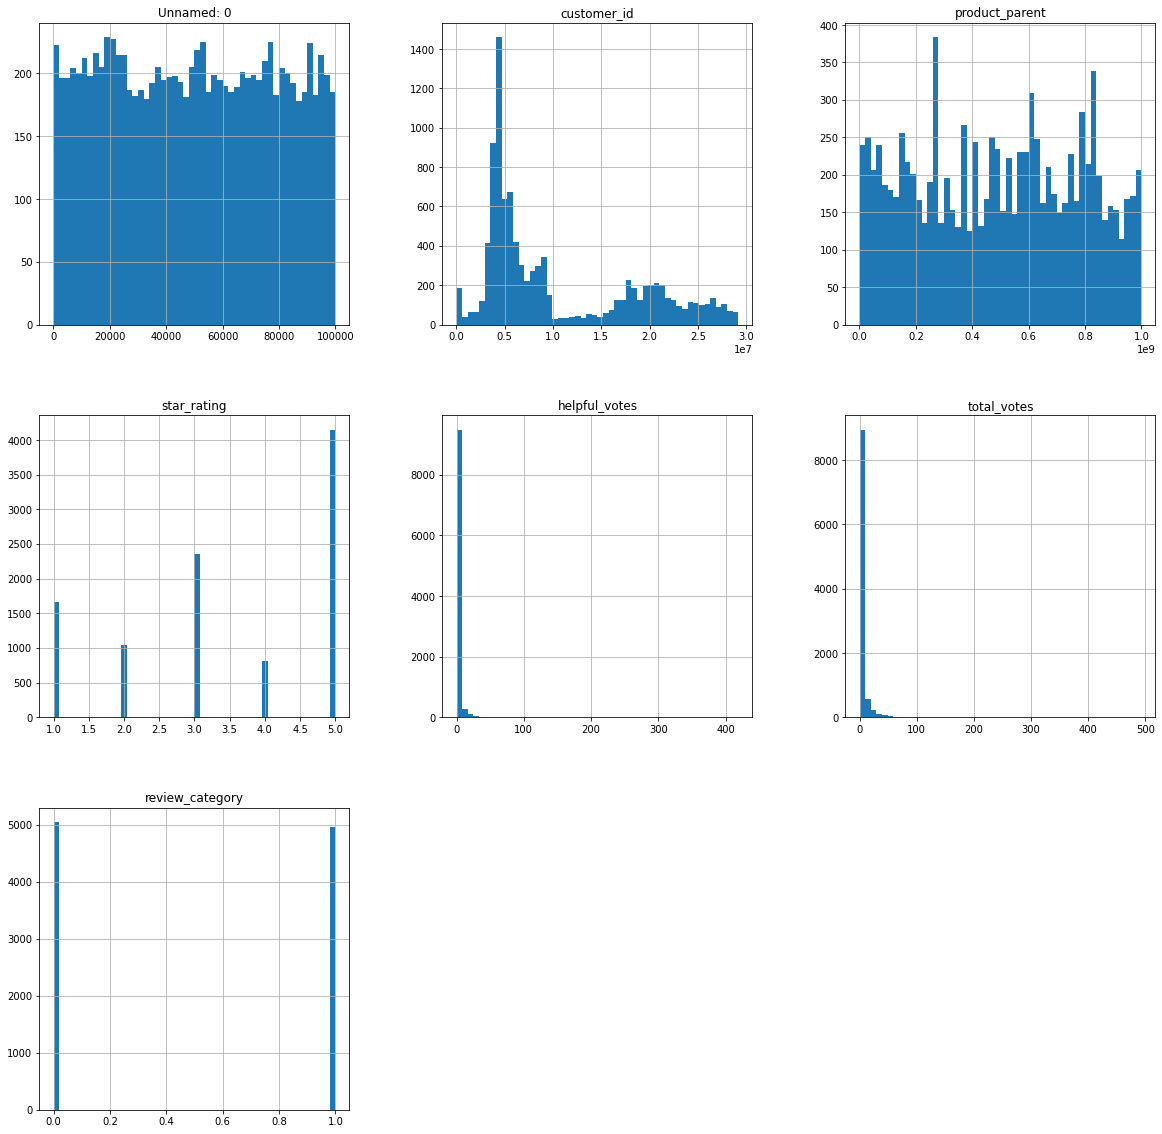

In [20]:
data.hist(bins=50, figsize=(20,20))


The count plot of  :  product_category
------------------------------


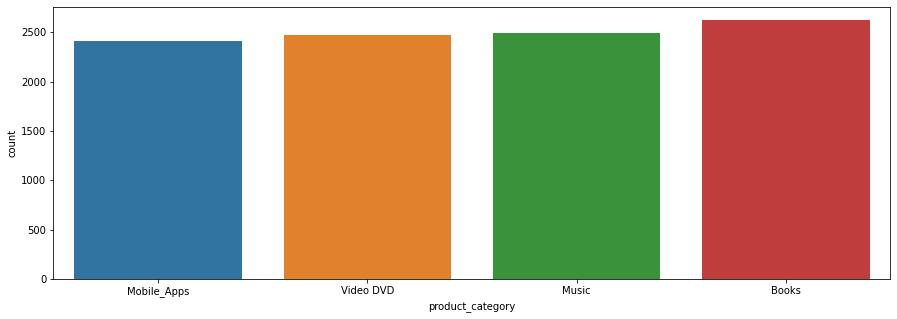


The count plot of  :  verified_purchase
------------------------------


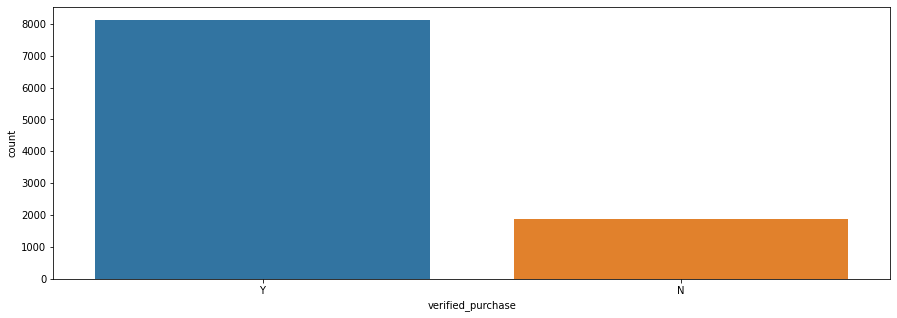


The count plot of  :  vine
------------------------------


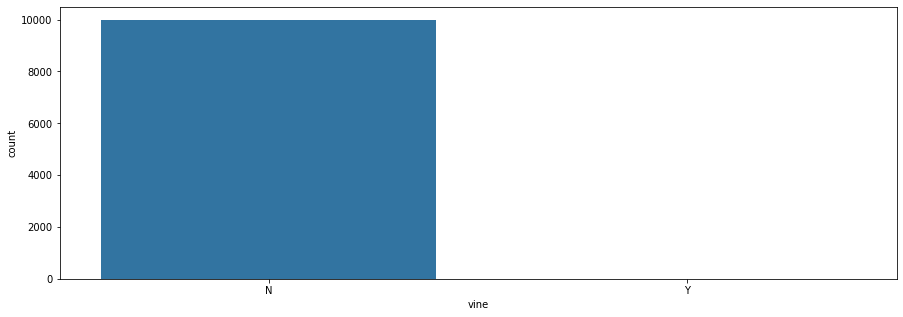


The count plot of  :  review_category
------------------------------


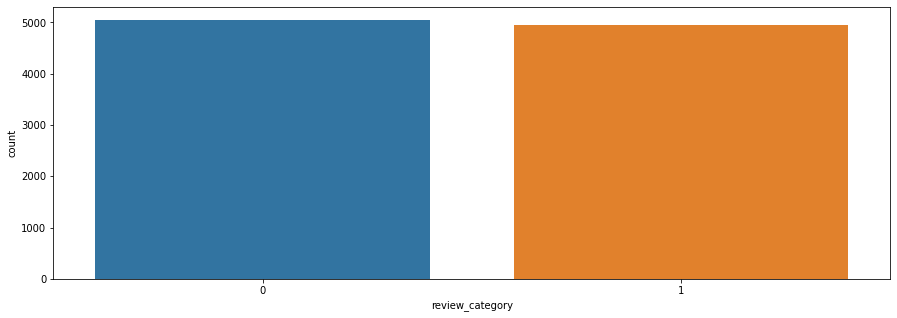


The count plot of  :  helpful_votes
------------------------------


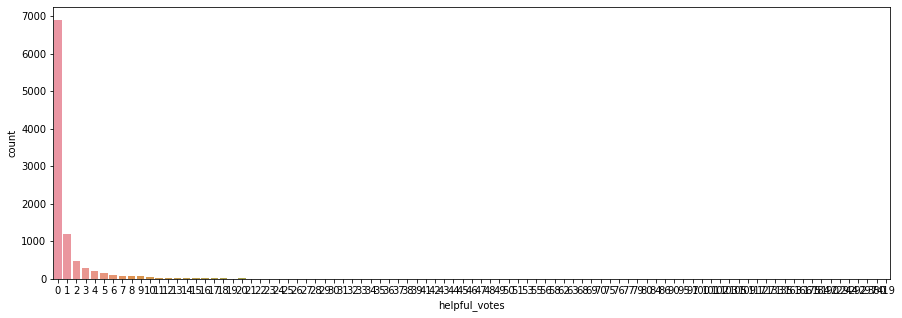


The count plot of  :  total_votes
------------------------------


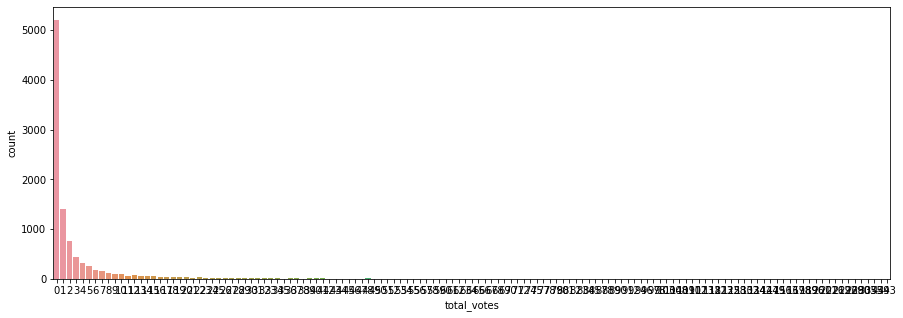

In [21]:
l=['product_category','verified_purchase','vine','review_category','helpful_votes', 'total_votes']

for i in l:
  print('The count plot of  : ', i)
  print('-'*30)
  plt.figure(figsize=(15,5))
  sns.countplot(data[i])
  plt.show()
  print()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc617ade10>,
      dtype=object)

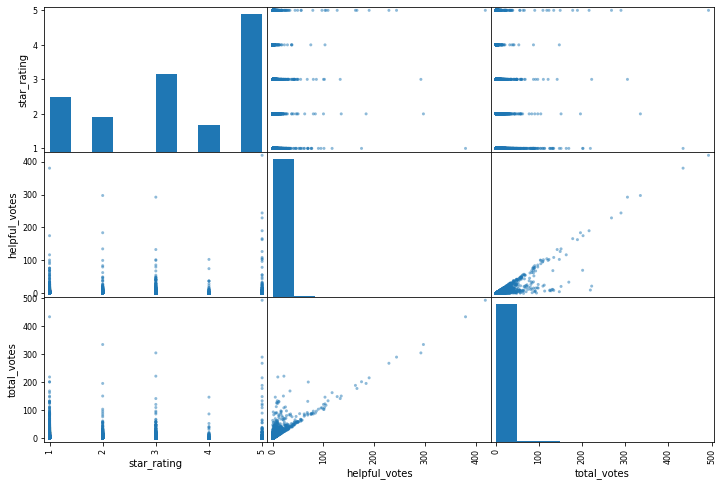

In [22]:
from pandas.plotting import scatter_matrix
attributes = ['star_rating', 'helpful_votes', 'total_votes']
scatter_matrix(data[attributes], figsize = (12,8))

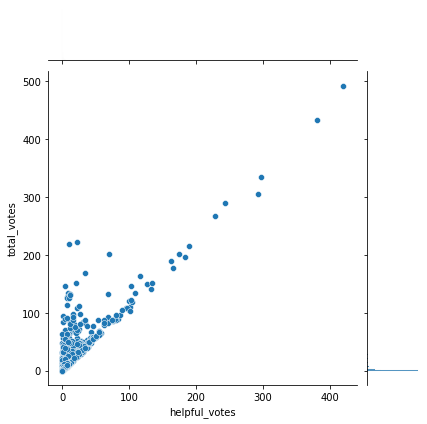

In [23]:
sns.jointplot(x='helpful_votes', y='total_votes', data=data)

**Adding Attribute**
Adding a new attribute named sentiment having binary values 0 and 1.
The rating below 4 is represented by 0 and 4 or above represented by 1.

In [24]:
def sentiment(n):
    return 1 if n>=4 else 0
data['sentiment'] = data['star_rating'].apply(sentiment)
data.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review,review_category,sentiment
0,35311,UK,4652511,R2PF9XCB2AOY7C,B00MNYTWMI,174964168,Midnight Castle – A Free Hidden Object Mystery...,Mobile_Apps,5,0,1,N,Y,2014-09-16,"Addictive game Very good game, the graphics ar...",1,1
1,44590,UK,8778070,R2OVRHVTCC7U18,B00I8Q77Y0,370420344,Flappy Wings (not Flappy Bird),Mobile_Apps,2,1,2,N,Y,2014-02-16,Where to start? I came on here because I wante...,0,0
2,90295,UK,8476187,RRPSNSVU2RNE4,B008PEHK6U,173475712,Man of Steel [DVD],Video DVD,3,1,5,N,N,2013-12-28,Really Disappointed in this Film I have to say...,0,0
3,38798,UK,4329864,R1WK44Y81XH276,B00NWLIW0E,13526192,Goat Simulator,Mobile_Apps,1,3,5,N,N,2014-12-26,"Rubbish game When I tried to open it, it said ...",0,0
4,43364,UK,8080547,R2UL591NPU40SN,B00HRC40T6,887316735,Shadow Blade,Mobile_Apps,1,0,0,N,Y,2015-06-29,One Star Come on,0,0


In [25]:
df_new=data[['star_rating','review', 'sentiment']]
df_new.head()

,star_rating,review,sentiment
0,5,"Addictive game Very good game, the graphics ar...",1
1,2,Where to start? I came on here because I wante...,0
2,3,Really Disappointed in this Film I have to say...,0
3,1,"Rubbish game When I tried to open it, it said ...",0
4,1,One Star Come on,0


In [26]:
data['star_rating'].value_counts()

5    4149
3    2350
1    1661
2    1035
4     804
Name: star_rating, dtype: int64

In [27]:
data['sentiment'].value_counts()

0    5046
1    4953
Name: sentiment, dtype: int64

## **NLTK**
Text preprocessing .
1-Removing website links
2-Removing html tags
3-Decontracting(expanding from the original form)
4-Removing the words with numeric digits
5-Removing non-word characters
6-Converting to lower case
7-Removing stop words
8-Performing Lemmatization


In [28]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [29]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stopwords] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
data['cleaned_text'] = data['review'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [30]:
data.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review,review_category,sentiment,cleaned_text
0,35311,UK,4652511,R2PF9XCB2AOY7C,B00MNYTWMI,174964168,Midnight Castle – A Free Hidden Object Mystery...,Mobile_Apps,5,0,1,N,Y,2014-09-16,"Addictive game Very good game, the graphics ar...",1,1,addictive game good game graphics brilliant gr...
1,44590,UK,8778070,R2OVRHVTCC7U18,B00I8Q77Y0,370420344,Flappy Wings (not Flappy Bird),Mobile_Apps,2,1,2,N,Y,2014-02-16,Where to start? I came on here because I wante...,0,0,start come want get flappy bird saw think basi...
2,90295,UK,8476187,RRPSNSVU2RNE4,B008PEHK6U,173475712,Man of Steel [DVD],Video DVD,3,1,5,N,N,2013-12-28,Really Disappointed in this Film I have to say...,0,0,really disappoint film say look forward remake...
3,38798,UK,4329864,R1WK44Y81XH276,B00NWLIW0E,13526192,Goat Simulator,Mobile_Apps,1,3,5,N,N,2014-12-26,"Rubbish game When I tried to open it, it said ...",0,0,rubbish game try open say stop fix higher rat
4,43364,UK,8080547,R2UL591NPU40SN,B00HRC40T6,887316735,Shadow Blade,Mobile_Apps,1,0,0,N,Y,2015-06-29,One Star Come on,0,0,one star come


**Adding Attribute:**
Adding a new attrinute named all_feature having combination of product_title and cleaned_text

In [31]:
def combined_feature(row):
    return row['product_id'] + ' '+ row['cleaned_text']
data['all_feature'] = data.apply(combined_feature, axis = 1)
data.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review,review_category,sentiment,cleaned_text,all_feature
0,35311,UK,4652511,R2PF9XCB2AOY7C,B00MNYTWMI,174964168,Midnight Castle – A Free Hidden Object Mystery...,Mobile_Apps,5,0,1,N,Y,2014-09-16,"Addictive game Very good game, the graphics ar...",1,1,addictive game good game graphics brilliant gr...,B00MNYTWMI addictive game good game graphics b...
1,44590,UK,8778070,R2OVRHVTCC7U18,B00I8Q77Y0,370420344,Flappy Wings (not Flappy Bird),Mobile_Apps,2,1,2,N,Y,2014-02-16,Where to start? I came on here because I wante...,0,0,start come want get flappy bird saw think basi...,B00I8Q77Y0 start come want get flappy bird saw...
2,90295,UK,8476187,RRPSNSVU2RNE4,B008PEHK6U,173475712,Man of Steel [DVD],Video DVD,3,1,5,N,N,2013-12-28,Really Disappointed in this Film I have to say...,0,0,really disappoint film say look forward remake...,B008PEHK6U really disappoint film say look for...
3,38798,UK,4329864,R1WK44Y81XH276,B00NWLIW0E,13526192,Goat Simulator,Mobile_Apps,1,3,5,N,N,2014-12-26,"Rubbish game When I tried to open it, it said ...",0,0,rubbish game try open say stop fix higher rat,B00NWLIW0E rubbish game try open say stop fix ...
4,43364,UK,8080547,R2UL591NPU40SN,B00HRC40T6,887316735,Shadow Blade,Mobile_Apps,1,0,0,N,Y,2015-06-29,One Star Come on,0,0,one star come,B00HRC40T6 one star come


**Creating a sub dataset named df_final containing attributes- sentiment, all_feature, cleaned_text**

In [32]:
df_final=data[[ 'sentiment', 'all_feature', 'cleaned_text']]
df_final.head()

,sentiment,all_feature,cleaned_text
0,1,B00MNYTWMI addictive game good game graphics b...,addictive game good game graphics brilliant gr...
1,0,B00I8Q77Y0 start come want get flappy bird saw...,start come want get flappy bird saw think basi...
2,0,B008PEHK6U really disappoint film say look for...,really disappoint film say look forward remake...
3,0,B00NWLIW0E rubbish game try open say stop fix ...,rubbish game try open say stop fix higher rat
4,0,B00HRC40T6 one star come,one star come


In [33]:
counts = data['cleaned_text'].value_counts()

In [34]:
counts.index = counts.index.map(str)

When star Rating is :  0
______________________________



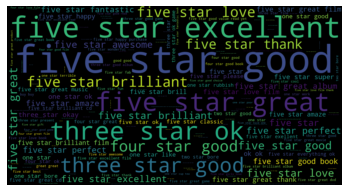

When star Rating is :  1
______________________________



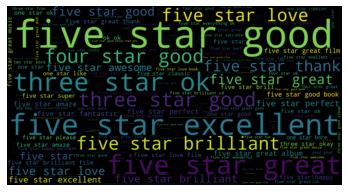

In [35]:
#most common words used
from wordcloud import WordCloud

for i in range (0,2):
  print('When star Rating is : ', i)
  print('_'*30)
  print()
  text = df_final[df_final['sentiment'] == i]
  all_words = ' '.join([text for text in text.cleaned_text])
  wordcloud = WordCloud(width= 1500, height= 800,
                              max_font_size = 170,
                              collocations = False).generate_from_frequencies(counts)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()
  

When sentiment is :  0
______________________________



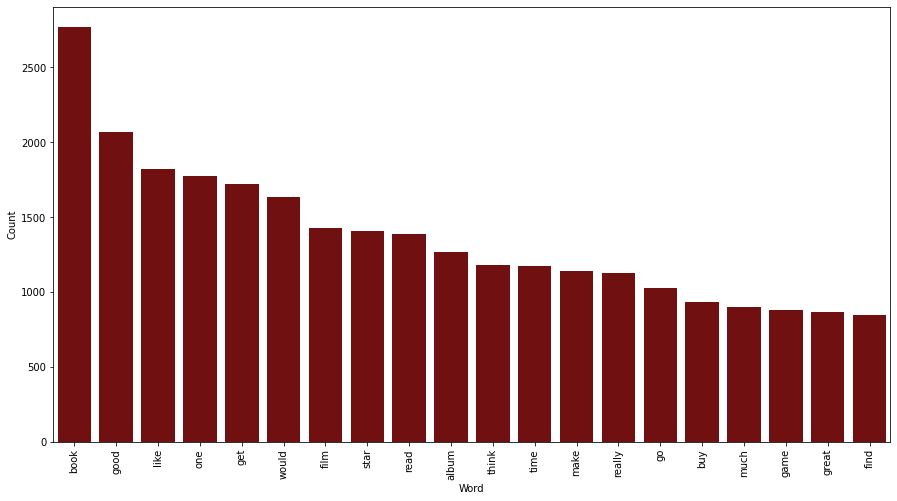


When sentiment is :  1
______________________________



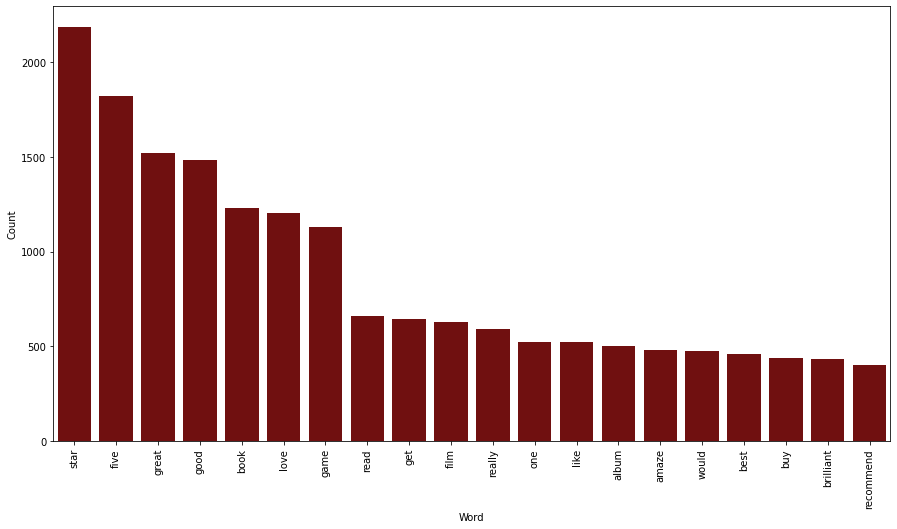

In [36]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(15,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'maroon')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()


for i in range(0,2):
  print('When sentiment is : ', i)
  print('_'*30)
  print()
  counter(df_final[df_final['sentiment'] == i], 'cleaned_text', 20)
  print()

**When the sentiment is 0 meand rating is less then 4 mostly used word in reviews is star and least used word is find**

**When the sentiment is 1 meand rating is 4 or greater mostly used word in review is star and least used word is recommend**

# **Model Building in ML**

In [37]:
x=df_final['cleaned_text']
y=df_final['sentiment']
print(x[:5])
print(y[:5])

0    addictive game good game graphics brilliant gr...
1    start come want get flappy bird saw think basi...
2    really disappoint film say look forward remake...
3        rubbish game try open say stop fix higher rat
4                                        one star come
Name: cleaned_text, dtype: object
0    1
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64


In [38]:
#countvectoriser with stemming

from sklearn.feature_extraction.text import CountVectorizer
CV=CountVectorizer(max_features=5000, ngram_range=(2,2))
x_stem=CV.fit_transform(x).toarray()
x_stem           

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Splitting data into training and testing with 80 20 ratio**

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(x_stem,y,test_size=0.2)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7999, 5000), (2000, 5000), (7999,), (2000,))

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 


from sklearn import metrics

In [42]:
clf_logit_pca = LogisticRegression()
clf_tree_pca = DecisionTreeClassifier()


clf_rf_pca= RandomForestClassifier(n_estimators=100)
clf_knn_pca= KNeighborsClassifier(n_neighbors=15)


In [43]:
classifiers = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier',
                'KNeighborsClassifier']

In [44]:
models = {clf_logit_pca: 'LogisticRegression', 
          clf_tree_pca: 'DecisionTreeClassifier', 
         
          clf_rf_pca: 'RandomForestClassifier',
          clf_knn_pca: 'KNN',
          }

In [45]:

def train(algo, name, X_train, y_train, X_test, y_test):
    algo.fit(X_train, y_train)
    y_test_pred = algo.predict(X_test)
    return y_test_pred


def performance(algo, name, X_test, y_test, y_test_pred):
    # Accuracy Score
    score = metrics.accuracy_score(y_test, y_test_pred)
    print('Accuracy score for', name, ':', score)
    
    # Confusion Metrics
    sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification Report
    print(metrics.classification_report(y_test, y_test_pred))
    
    # ROC AUC Score
    prob = algo.predict_proba(X_test)
    prob = prob[:, 1]
    roc_auc = metrics.roc_auc_score(y_test, prob)
    print(roc_auc)
    
    # Plotting ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, prob)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.show()
    
    return roc_auc


def main(models):
    auc = []
    for algo, name in models.items():
        print('#'*40, name, '#'*40)
        y_test_pred = train(algo, name, X_train, y_train, X_test, y_test)
        roc_auc = performance(algo, name, X_test, y_test, y_test_pred)
        auc.append(roc_auc)
    return auc

######################################## LogisticRegression ########################################
Accuracy score for LogisticRegression : 0.823


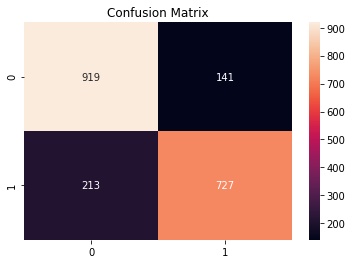

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1060
           1       0.84      0.77      0.80       940

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

0.9141404054596548


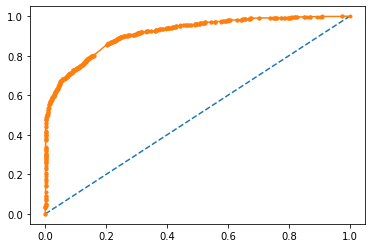

######################################## DecisionTreeClassifier ########################################
Accuracy score for DecisionTreeClassifier : 0.734


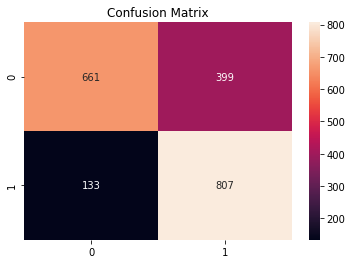

              precision    recall  f1-score   support

           0       0.83      0.62      0.71      1060
           1       0.67      0.86      0.75       940

    accuracy                           0.73      2000
   macro avg       0.75      0.74      0.73      2000
weighted avg       0.76      0.73      0.73      2000

0.7942849257326374


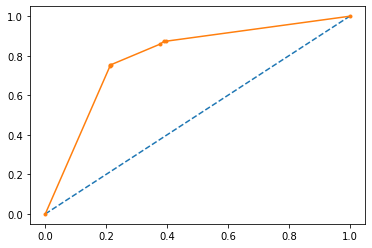

######################################## RandomForestClassifier ########################################
Accuracy score for RandomForestClassifier : 0.789


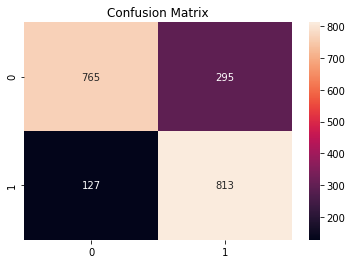

              precision    recall  f1-score   support

           0       0.86      0.72      0.78      1060
           1       0.73      0.86      0.79       940

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000

0.8940736651947008


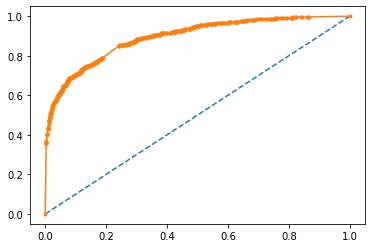

######################################## KNN ########################################
Accuracy score for KNN : 0.672


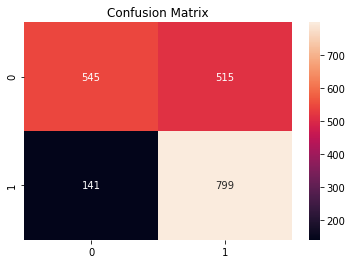

              precision    recall  f1-score   support

           0       0.79      0.51      0.62      1060
           1       0.61      0.85      0.71       940

    accuracy                           0.67      2000
   macro avg       0.70      0.68      0.67      2000
weighted avg       0.71      0.67      0.66      2000

0.8213393215576074


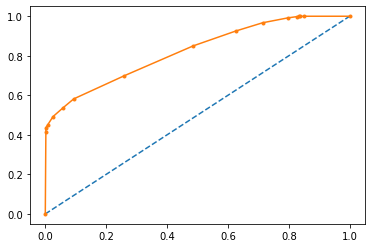

In [46]:
auc = main(models)

In [47]:
model_comp_df = pd.DataFrame(auc, columns = ['ROC AUC'], index = classifiers)
model_comp_df.sort_values(by='ROC AUC', ascending=False)

,ROC AUC
LogisticRegression,0.914140
RandomForestClassifier,0.894074
KNeighborsClassifier,0.821339
DecisionTreeClassifier,0.794285


**I have used four model here and according to the results LogisticRegression Model fits best here with accuracy of approximately 92%**

# **Model Building in DL**

**Spliting data** 

In [48]:
train_df, test_df = train_test_split(df_final, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)


Training data size :  (7999, 3)
Test data size :  (2000, 3)


**Model Building**

In [49]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['sentiment']

In [50]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(200))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 32)           192032    
_________________________________________________________________
lstm (LSTM)                  (None, 200)               186400    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 378,633
Trainable params: 378,633
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(X_train,y_train, epochs=20, batch_size=8, validation_split=0.2)

Epoch 1/20
800/800 [==============================] - 31s 12ms/step - loss: 0.4963 - accuracy: 0.7517 - val_loss: 0.2772 - val_accuracy: 0.8781
Epoch 2/20
800/800 [==============================] - 9s 11ms/step - loss: 0.2144 - accuracy: 0.9203 - val_loss: 0.2728 - val_accuracy: 0.8831
Epoch 3/20
800/800 [==============================] - 9s 11ms/step - loss: 0.1367 - accuracy: 0.9515 - val_loss: 0.2957 - val_accuracy: 0.8863
Epoch 4/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0924 - accuracy: 0.9713 - val_loss: 0.3293 - val_accuracy: 0.8856
Epoch 5/20
800/800 [==============================] - 8s 11ms/step - loss: 0.0678 - accuracy: 0.9787 - val_loss: 0.3838 - val_accuracy: 0.8781
Epoch 6/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0431 - accuracy: 0.9883 - val_loss: 0.4417 - val_accuracy: 0.8775
Epoch 7/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0398 - accuracy: 0.9872 - val_loss: 0.5705 - val_accuracy: 0.879

**Evaluating model performance on test data**

In [52]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['sentiment']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.861
F1-score:  0.8571428571428572
Confusion matrix:


array([[888, 141],
       [137, 834]])

**After adding dropout** Accuracy Increased

In [53]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
dropout (Dropout)            (None, 130, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(X_train,y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
100/100 [==============================] - 4s 20ms/step - loss: 0.6261 - accuracy: 0.6533 - val_loss: 0.3349 - val_accuracy: 0.8694
Epoch 2/5
100/100 [==============================] - 1s 14ms/step - loss: 0.3181 - accuracy: 0.8875 - val_loss: 0.2849 - val_accuracy: 0.8825
Epoch 3/5
100/100 [==============================] - 1s 14ms/step - loss: 0.1765 - accuracy: 0.9384 - val_loss: 0.2928 - val_accuracy: 0.8775
Epoch 4/5
100/100 [==============================] - 1s 13ms/step - loss: 0.2051 - accuracy: 0.9316 - val_loss: 0.2929 - val_accuracy: 0.8894
Epoch 5/5
100/100 [==============================] - 1s 13ms/step - loss: 0.1179 - accuracy: 0.9605 - val_loss: 0.3167 - val_accuracy: 0.8856


**Evaluating model performance on test data after adding dropout**

In [55]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['sentiment']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.8865
F1-score:  0.8826873385012919
Confusion matrix:


array([[919, 110],
       [117, 854]])

**Here the Deep learniong model gives accuracy of approx 87%**

#**Polarity**
Polarity analysis takes into account the amount of positive and negative terms  that appear in a given sentence.
Here we calculate polarity of reviews of customers.


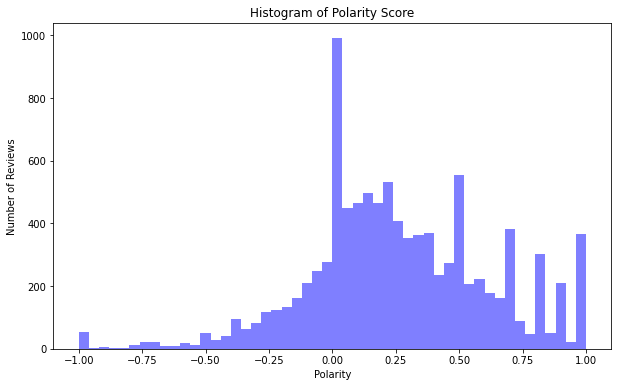

In [56]:
from textblob import TextBlob
df_new['review']= df_new['review'].astype(str) #Make sure about the correct data type
pol = lambda x: TextBlob(x).sentiment.polarity
df_new['polarity'] = df_new['review'].apply(pol) 
import matplotlib.pyplot as plt
import seaborn as sns
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_new.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

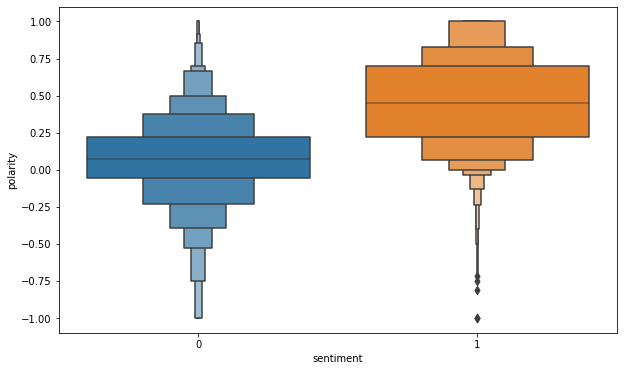

In [57]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='sentiment', y='polarity', data=df_new)
plt.show();

# **Subjectivity**

In [58]:
sub = lambda x: TextBlob(x).sentiment.subjectivity
df_new['subjectivity'] = df_new['review'].apply(sub)
df_new.sample(10)

,star_rating,review,sentiment,polarity,subjectivity
5167,4,"Four Stars this product also good,movie is goo...",1,0.700000,0.600000
9546,3,Tilda Characters Collection. Great little book...,0,0.073307,0.528125
6319,3,thought it would be better I like Rita but not...,0,0.450000,0.700000
3107,5,360 anivrus review Have had no problems thus f...,1,-0.012500,1.000000
4742,5,AmAzInG If you connect to facebook an the to ...,1,0.236111,0.747222
5186,3,A Most Wanted Man isn't Our Man in Havana but ...,0,0.214076,0.534824
735,3,"James Blunt The song \\""""beautiful\\"""" is a de...",0,0.091111,0.529444
5652,5,Perfect The ARTPOP is just another good cd by ...,1,0.800000,0.900000
6696,5,Five Stars great,1,0.800000,0.750000
3229,5,Five Stars loved the film & arrived on time,1,0.700000,0.800000


Text(0.5, 1.0, 'Distribution of Subjectivity Score')

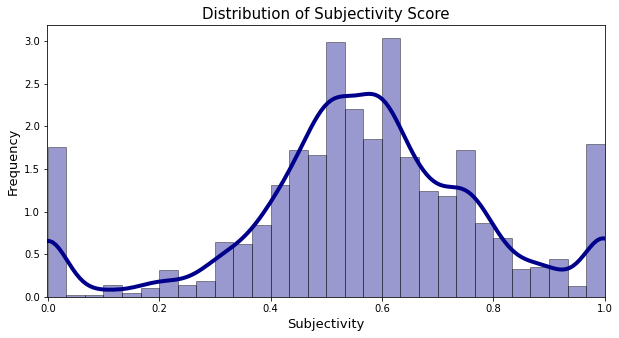

In [59]:
# Density Plot and Histogram of subjectivity
plt.figure(figsize=(10,5))
sns.distplot(df_new['subjectivity'], hist=True, kde=True,
bins=int(30), color = 'darkblue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity Score', fontsize=15)

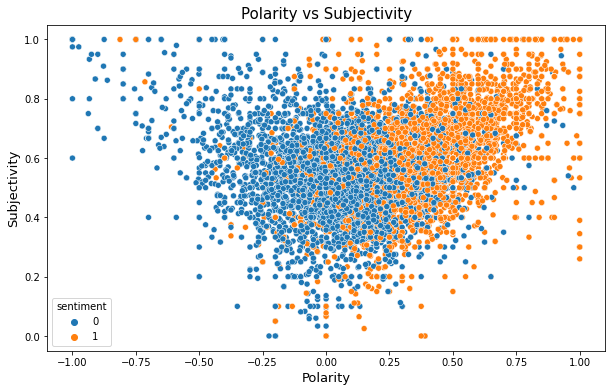

In [60]:
# polarity vs subjectivity plotting
plt.figure(figsize=(10,6))
sns.scatterplot(x='polarity', y='subjectivity', hue="sentiment", data=df_new)
plt.xlabel('Polarity', fontsize=13)
plt.ylabel('Subjectivity', fontsize=13)
plt.title('Polarity vs Subjectivity', fontsize=15)
plt.show();